# Landau-Zener Problem as Benchmark

In [225]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from qopt import *
import qopt.tensorflow_optimize
import qopt.tensorflow_simulator
import qopt.tensorflow_cost_func
import qopt.tensorflow_solver_algs
from qopt.tensorflow_util import DEFAULT_FLOAT_TYPE, DEFAULT_COMPLEX_TYPE

from importlib import reload
reload(qopt.tensorflow_simulator)
reload(qopt.tensorflow_solver_algs)
reload(qopt.tensorflow_cost_func)
reload(qopt.tensorflow_optimize)

from scipy.constants import physical_constants, elementary_charge, giga, \
    micro

# ############################ Physical Constants #############################

hbar = physical_constants["reduced Planck constant"][0]
micro_eV_by_inverse_nano_seconds = elementary_charge / hbar / giga * micro


total_time = .1
n_time_steps = 200
delta_t = total_time / n_time_steps
tunnel_coupling = 100 * micro_eV_by_inverse_nano_seconds

minimal_detuning = - 1000 * micro_eV_by_inverse_nano_seconds
maximal_detuning = 1000 * micro_eV_by_inverse_nano_seconds
initial_detuning = minimal_detuning
final_detuning = maximal_detuning
boundaries = np.zeros(shape=(n_time_steps, 2), dtype=float)
boundaries[:, 0] = minimal_detuning
boundaries[:, 1] = maximal_detuning

# We want to ensure a transition, so we need to make sure that the final and initial values are fixed:
boundaries[0, 1] = minimal_detuning
boundaries[-1, 0] = maximal_detuning

h_ctrl = [-.5 * DenseOperator.pauli_z()]
h_drift = n_time_steps * [-.5 * tunnel_coupling * DenseOperator.pauli_x()]

tau = delta_t * np.ones(n_time_steps)

In [226]:
initial_hamiltonian = initial_detuning * h_ctrl[0] + h_drift[0]
eig_vals_inital_ham, eig_vecs_inital_ham = initial_hamiltonian.spectral_decomposition(hermitian=True)

final_hamiltonian = final_detuning * h_ctrl[0] + h_drift[-1]
eig_vals_final_ham, eig_vecs_final_ham = initial_hamiltonian.spectral_decomposition(hermitian=True)

initial_state_vector = np.expand_dims(eig_vecs_inital_ham[:, 0], axis=1)
final_state_vector = np.expand_dims(eig_vecs_final_ham[:, 0], axis=1)




In [227]:
solver = qopt.tensorflow_solver_algs.TensorFlowSolver(
    h_ctrl=h_ctrl,
    h_drift=h_drift,
    tau=tau,
    initial=initial_state_vector  # We start in the ground state
)

cost_func = qopt.tensorflow_cost_func.TensorFlowStateInfidelity(
    target=final_state_vector,  # We want to terminate in the instantaneous ground state
    solver=solver
)

simulator = qopt.tensorflow_simulator.TensorFlowSimulator(
    solver=solver,
    cost_func=cost_func
)

optimizer = qopt.tensorflow_optimize.TensorFlowScipyOptimizer(
    simulator=simulator,
    boundaries=boundaries
)

In [228]:
initial_values = np.linspace(minimal_detuning, maximal_detuning, n_time_steps, endpoint=True)
initial_values_tf = np.expand_dims(initial_values, axis=1)
initial_values_tf = tf.constant(initial_values_tf, dtype=DEFAULT_FLOAT_TYPE)


simulator.value_and_gradient(opt_pars=tf.Variable(initial_values_tf, dtype=DEFAULT_FLOAT_TYPE))

(<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[0.74246278]])>,
 <tf.Tensor: shape=(200, 1), dtype=complex128, numpy=
 array([[ 1.94020653e-05-1.19509152e-04j],
        [ 1.99971347e-05-1.35321864e-04j],
        [ 9.57351329e-06-1.47241771e-04j],
        [-6.19576481e-06-1.48876247e-04j],
        [-1.89605713e-05-1.39421095e-04j],
        [-2.21393710e-05-1.23830172e-04j],
        [-1.41840447e-05-1.10040555e-04j],
        [ 8.77307374e-07-1.04884315e-04j],
        [ 1.56624007e-05-1.10804697e-04j],
        [ 2.31209279e-05-1.24891837e-04j],
        [ 1.98213861e-05-1.40497871e-04j],
        [ 7.35255896e-06-1.50464747e-04j],
        [-8.63260822e-06-1.50363684e-04j],
        [-2.11010287e-05-1.40308507e-04j],
        [-2.47335011e-05-1.24681410e-04j],
        [-1.80772967e-05-1.10074165e-04j],
        [-3.94733268e-06-1.02462175e-04j],
        [ 1.19269986e-05-1.04831125e-04j],
        [ 2.33085189e-05-1.16158494e-04j],
        [ 2.58775069e-05-1.32019093e-04j],
        [ 1.87

In [229]:
result = optimizer.run_optimization(initial_values)

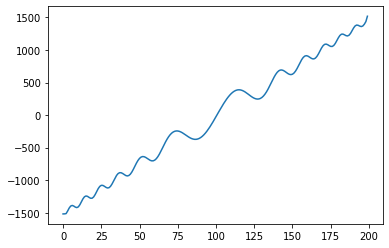

In [230]:
plt.plot(result.x)
plt.savefig(r'C:\Users\julia\Desktop\Work\Documentation\2022_08_21_Tensorflow_qopt\SamplePicture\first_result.pdf')

In [231]:
result

      fun: array(2.34068676e-09)
 hess_inv: <200x200 LbfgsInvHessProduct with dtype=float64>
      jac: array([ 2.33615895e-09,  1.51832710e-09, -1.42199151e-10, -1.73071065e-09,
       -2.40453743e-09, -1.83959248e-09, -3.26255153e-10,  1.41444053e-09,
        2.55765986e-09,  2.54948504e-09,  1.39060263e-09, -3.54347619e-10,
       -1.86346368e-09, -2.47528795e-09, -1.95582893e-09, -5.29839077e-10,
        1.24780142e-09,  2.69572288e-09,  3.24705125e-09,  2.67740406e-09,
        1.21397320e-09, -5.63536260e-10, -1.98757984e-09, -2.57177838e-09,
       -2.15022605e-09, -8.74403527e-10,  8.69560203e-10,  2.57217786e-09,
        3.72917078e-09,  3.98449840e-09,  3.25379991e-09,  1.76465908e-09,
       -2.59166921e-11, -1.60172305e-09, -2.55480257e-09, -2.67766921e-09,
       -1.97129618e-09, -6.04459197e-10,  1.13890126e-09,  2.91020352e-09,
        4.34986836e-09,  5.15231290e-09,  5.13732599e-09,  4.30412803e-09,
        2.83804801e-09,  1.05767570e-09, -6.77188863e-10, -2.05589988e-

In [232]:
simulator.value_and_gradient(opt_pars=tf.Variable(np.expand_dims(result.x, axis=1), dtype=DEFAULT_FLOAT_TYPE))[0]


<tf.Tensor: shape=(1, 1), dtype=float64, numpy=array([[2.34068676e-09]])>

### Acknowledgements

I thank Alessandro David for the suggestion of the Landau-Zener problem for benchmarking.

## Let's compare to native qopt

I leave this for now, but it might be a bit boring, if the results coincide exactly.


In [235]:
solver_qopt = SchroedingerSolver(
    h_drift=h_drift,
    h_ctrl=h_ctrl,
    tau=tau,
    initial_state=DenseOperator(initial_state_vector)
)

cost_func_qopt = StateInfidelity(
    target=DenseOperator(final_state_vector),  # We want to terminate in the instantaneous ground state
    solver=solver_qopt
)

simulator_qopt = Simulator(
    solvers = [solver_qopt, ],
    cost_funcs = [cost_func_qopt, ]
)

optimizer_qopt = ScalarMinimizingOptimizer(
    system_simulator=simulator_qopt,
    bounds=boundaries,
)

In [236]:
initial_values_2dim = np.expand_dims(initial_values, axis=1)
result_qopt = optimizer_qopt.run_optimization(initial_values_2dim)

In [237]:
result_qopt

<AxesSubplot:xlabel='Iteration', ylabel='Costs'>

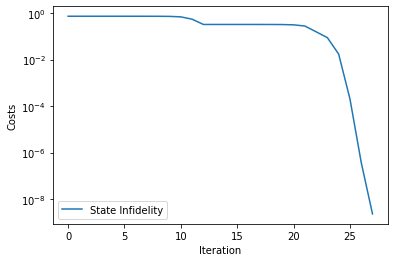

In [238]:
data = DataContainer()
data.append_optim_result(result_qopt)
analyzer = Analyser(data=data)
analyzer.plot_costs()

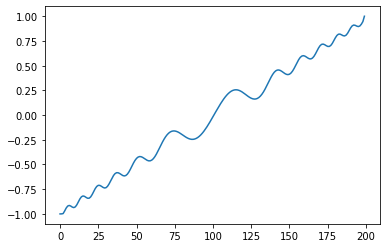

In [239]:
plt.plot(result_qopt.final_parameters / micro_eV_by_inverse_nano_seconds / 1000)

In [ ]:
simulator.value_and_gradient(opt_pars=tf.Variable(result_qopt.final_parameters, dtype=DEFAULT_FLOAT_TYPE))[0]


In [ ]:
plt.plot(result.x - np.squeeze(result_qopt.final_parameters))